In [62]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

In [89]:
class Processor(processor.ProcessorABC):
    def __init__(self, wp_btag=0.2):
        self._wp_btag = wp_btag
        
    @property
    def accumulator(self):
        return {
            "sumw": defaultdict(float),
            "cutflow": (
                            Hist.new.StrCategory(
                                [], name="dataset", label="Dataset", growth=True
                            ).StrCategory(
                                [], name="cat", label="Category", growth=True
                            ).Reg(
                                50, 40, 220, name="msoftdrop", label=r"msoftdrop"
                            ).Reg(
                                50, 150, 700, name="pt", label=r"$p_T$"
                            ).Reg(
                                50, 0, 1, name="pn_Hbb", label=r"H(bb) vs QCD score"
                            ).IntCategory(
                                [], name="cut", label="Cut Idx", growth=True
                            ).Double()
                        ),
            "met": (
                            Hist.new.StrCategory(
                                [], name="dataset", label="Dataset", growth=True
                            ).StrCategory(
                                [], name="region", label="Region", growth=True
                            ).Reg(
                                50, 0, 400, name="pt", label=r"MET $p_T$"
                            ).Double()
                        ),
            "goodmuon": (
                            Hist.new.StrCategory(
                                [], name="dataset", label="Dataset", growth=True
                            ).StrCategory(
                                [], name="region", label="Region", growth=True
                            ).Reg(
                                50, 0, 400, name="pt", label=r"Leading muon $p_T$"
                            ).Double()
                        ),
            "leptonicW": (
                            Hist.new.StrCategory(
                                [], name="dataset", label="Dataset", growth=True
                            ).StrCategory(
                                [], name="region", label="Region", growth=True
                            ).Reg(
                                50, 0, 400, name="pt", label=r"Leptonic W $p_T$"
                            ).Double()
                        ),
            "ak4bjet": (
                            Hist.new.StrCategory(
                                [], name="dataset", label="Dataset", growth=True
                            ).StrCategory(
                                [], name="region", label="Region", growth=True
                            ).Reg(
                                50, 0, 50, name="njets", label=r"Number of dphi(AK4 jet, Leading muon) < 2"
                            ).Reg(
                                50, 0, 1.1, name="pn_b_1", label=r"Leading AK4 b vs g score"
                            ).Double()
                        ),
            "ak8jet": (
                            Hist.new.StrCategory(
                                [], name="dataset", label="Dataset", growth=True
                            ).StrCategory(
                                [], name="region", label="Region", growth=True
                            ).Reg(
                                50, 0, 10, name="njets", label=r"Number of dphi(AK8 jet, Leading muon) > 2"
                            ).Reg(
                                50, 0, 400, name="pt", label=r"Leading AK8 $p_T$"
                            ).Double()
                        ),
        }
           
        
    def process(self, events):
        
        output = self.accumulator
        dataset = events.metadata['dataset']
        
        isRealData = not hasattr(events, "genWeight")
        
        selection = PackedSelection()
        
        if not isRealData:
            output['sumw'][dataset] += ak.sum(events.genWeight)
            
        if len(events) == 0:
            return output
        
        fatjets = events.ScoutingFatJet
        fatjets["pn_Hbb"] = ak.where(
            (fatjets.particleNet_prob_Hbb + fatjets.particleNet_prob_QCD) == 0, 
            0, 
            (fatjets.particleNet_prob_Hbb / (fatjets.particleNet_prob_Hbb + fatjets.particleNet_prob_QCD))
        )
        
        jets = events.ScoutingJet
        jets["pn_b"] = ak.where(
            (jets.particleNet_prob_b + jets.particleNet_prob_g) == 0, 
            0, 
            (jets.particleNet_prob_b / (jets.particleNet_prob_b + jets.particleNet_prob_g))
        )
        
        # trigger
        selection.add("trigger", events.HLT["Mu50"])
        
        # large radius jet
        selection.add("fatjetpt", ak.firsts(fatjets).pt > 200)
        
        # MET
        met = events.ScoutingMET
        selection.add('met', met.pt > 50)
        
        # Good muon
        goodmuon = (
            (events.ScoutingMuon.pt > 55)
            & (abs(events.ScoutingMuon.eta) < 2.4)
            & (abs(events.ScoutingMuon.trk_dxy) < 0.2)
            #& (abs(events.ScoutingMuon.trk_dz) < 0.5)
            #& (events.ScoutingMuon["type"] == 2)
            & (events.ScoutingMuon.normchi2 < 10)
            & (events.ScoutingMuon.nValidRecoMuonHits > 0)
            & (events.ScoutingMuon.nRecoMuonMatchedStations > 1)
            & (events.ScoutingMuon.nValidPixelHits > 0)
            & (events.ScoutingMuon.nTrackerLayersWithMeasurement > 5)            
        )
        nmuons = ak.sum(goodmuon, axis=1)
        selection.add('onemuon', (nmuons > 0))
        
        # Leptonic W 
        leadingmuon = ak.firsts(events.ScoutingMuon[goodmuon])
        leptonicW = met + leadingmuon
        selection.add('leptonicW', leptonicW.pt > 150)
        
        # Same. hem. AK4 b-jet
        dphi = abs(jets.delta_phi(leadingmuon))
        jetsamehemisp = jets[dphi < 2]
        bjets = (jetsamehemisp.pn_b > self._wp_btag)
        nbjets = ak.sum(bjets, axis=1)
        selection.add('onebjet', (nbjets > 0))

        # Opp. hem. AK8 jet
        dphi = abs(fatjets.delta_phi(leadingmuon))
        is_away = (dphi > 2)
        nfatjets = ak.sum(is_away, axis=1)
        selection.add('onefatjet', (nfatjets > 0))
        
        proxy = ak.firsts(fatjets[(is_away)])
        
        if not isRealData:
            proxy = self.category(events, proxy)
            
        regions = {
            'all': ['trigger', 'fatjetpt', 'met','onemuon','leptonicW','onebjet','onefatjet'],
        }
        
        def normalize(val, cut):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
            
        for region, cuts in regions.items():
            if region == "noselection":
                continue
            allcuts = set([])
            cut = selection.all(*allcuts)
            
            output['cutflow'].fill(
                dataset=dataset,
                cat=normalize(proxy.cat, cut) if not isRealData else "data",
                msoftdrop=normalize(proxy.msoftdrop, cut),
                pt=normalize(proxy.pt, cut),
                pn_Hbb=normalize(proxy.pn_Hbb, cut),
                cut=0,
            )
            
            for i, cut in enumerate(cuts):
                allcuts.add(cut)
                cut = selection.all(*allcuts)
                
                output['cutflow'].fill(
                    dataset=dataset,
                    cat=normalize(proxy.cat, cut) if not isRealData else "data",
                    msoftdrop=normalize(proxy.msoftdrop, cut),
                    pt=normalize(proxy.pt, cut),
                    pn_Hbb=normalize(proxy.pn_Hbb, cut),
                    cut=i+1,
                )
                
        def fill(region):
            selections = regions[region]
            cut = selection.all(*selections)
            
            output['met'].fill(
                dataset=dataset,
                region=region,
                pt=normalize(met.pt, cut),
            )
            
            output['goodmuon'].fill(
                dataset=dataset,
                region=region,
                pt=normalize(leadingmuon.pt, cut),
            )
            
            output['leptonicW'].fill(
                dataset=dataset,
                region=region,
                pt=normalize(leptonicW.pt, cut),
            )

            output['ak4bjet'].fill(
                dataset=dataset,
                region=region,
                njets=normalize(ak.num(jetsamehemisp), cut),
                pn_b_1=normalize(ak.firsts(jetsamehemisp)["pn_b"], cut),
            )
            
            output['ak8jet'].fill(
                dataset=dataset,
                region=region,
                pt=normalize(proxy.pt, cut),
                njets=normalize(ak.num(dphi), cut),
            )
            
        for region in regions:
            fill(region)

        return output
    
    def postprocess(self, accumulator):
        return accumulator
    
    def category(self, events, jet):

        # get hadronic W
        w = events.GenPart[
            (abs(events.GenPart.pdgId) == 24)
            & (events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy']))
        ]

        w_is_had = ak.any(
            (abs(w.distinctChildren.pdgId) < 7)
            & (w.distinctChildren.hasFlags(['isLastCopy']))
        , axis=2)
        had_w = w[w_is_had]

        near_W, near_W_dr = jet.nearest(had_w, axis=None, threshold=0.8, return_metric=True)
        near_W_dr = ak.to_numpy(ak.fill_none(near_W_dr, 99))

        q_W = near_W.distinctChildren
        q_W_dr = jet.delta_r(q_W)
        index_descend_q_W = ak.argsort(q_W_dr, axis=1, ascending=False)
        q_W_dr_descend = q_W_dr[index_descend_q_W]

        # get hadronic top
        top = events.GenPart[
            (abs(events.GenPart.pdgId) == 6)
            & (events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy']))
        ]

        w_top = top.distinctChildren[
            (abs(top.distinctChildren.pdgId) == 24)
            & (top.distinctChildren.hasFlags(['isLastCopy']))
        ]
        w_top = ak.flatten(w_top, axis=2)

        w_top_is_had = ak.any(
            (abs(w_top.distinctChildren.pdgId) < 7)
            & (w_top.distinctChildren.hasFlags(['isLastCopy']))
        , axis=2)

        had_top = w_top[w_top_is_had].distinctParent

        near_top, near_top_dr = jet.nearest(had_top, axis=None, threshold=0.8, return_metric=True)
        near_top_dr = ak.to_numpy(ak.fill_none(near_top_dr, 99))

        b_near_top = near_top.distinctChildren[abs(near_top.distinctChildren.pdgId) == 5]
        b_near_top_matched, b_near_top_dr = jet.nearest(b_near_top, axis=None, threshold=0.8, return_metric=True)
        b_near_top_dr = ak.to_numpy(ak.fill_none(b_near_top_dr, 99))

        W_near_top = near_top.distinctChildren[(
            (abs(near_top.distinctChildren.pdgId) == 24)
            & (ak.any(abs(near_top.distinctChildren.distinctChildren.pdgId) < 7))
        )]

        q_W_near_top = ak.flatten(W_near_top.distinctChildren, axis=2)
        q_W_near_top_dr = jet.delta_r(q_W_near_top)

        index_ascend = ak.argsort(q_W_near_top_dr, axis=1)
        index_descend = ak.argsort(q_W_near_top_dr, ascending=False, axis=1)
        q_W_near_top_ascend = q_W_near_top[index_ascend]
        q_W_near_top_descend = q_W_near_top[index_descend]
        q_W_near_top_dr_ascend = q_W_near_top_dr[index_ascend]
        q_W_near_top_dr_descend = q_W_near_top_dr[index_descend]

        jet["dr_T"] = near_top_dr
        jet["dr_T_b"] = b_near_top_dr
        jet["dr_T_Wq_max"] = ak.fill_none(ak.firsts(q_W_near_top_dr_descend), 99)
        jet["dr_T_Wq_min"] = ak.fill_none(ak.firsts(q_W_near_top_dr_ascend), 99)
        jet["dr_T_Wq_max_pdgId"] = ak.fill_none(ak.firsts(q_W_near_top_descend).pdgId, 99)
        jet["dr_T_Wq_min_pdgId"] = ak.fill_none(ak.firsts(q_W_near_top_ascend).pdgId, 99)
        jet["dr_W_daus"] = ak.fill_none(ak.firsts(q_W_dr_descend), 99)

        top_matched = (
            (jet["dr_T_b"] < 0.8) 
            & (jet["dr_T_Wq_max"] < 0.8)
        )
        w_matched = (
            (
                (jet["dr_T_Wq_max_pdgId"] == 99) 
                & (jet["dr_W_daus"] < 0.8)
            ) | (
                (jet["dr_T_Wq_max_pdgId"] != 99) 
                & (jet["dr_T_b"] >= 0.8) 
                & (jet["dr_T_Wq_max"] < 0.8)
            )
        )
        non_matched = (
            (~top_matched) 
            & (~w_matched)
        )

        cat = np.repeat("ERROR", len(jet.pt))
        cat = ["top_matched" if t else c for c, t in zip(cat, top_matched.to_numpy())]
        cat = ["w_matched" if w else c for c, w in zip(cat, w_matched.to_numpy())]
        cat = ["non_matched" if n else c for c, n in zip(cat, non_matched.to_numpy())]
        jet["cat"] = cat
        
        return jet

In [90]:
fileset = {
    "TTtoLNu2Q" : [
        "root://eosuser.cern.ch//eos/user/a/adlintul/TTtoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/Run3Summer22/230131_071621/0000/nanoaod_1.root"
    ],
    "Run2022D" : [
        "root://eosuser.cern.ch//eos/user/a/adlintul/ScoutingPFRun3/Run2022D/230206_163934/0000/scoutingnano_1.root"
    ],
}

p = Processor()

futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema = ScoutingNanoAODSchema,
    maxchunks = 10,
)

out = futures_run(
    fileset,
    treename="Events",
    processor_instance=p
)

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


In [91]:
out

{'sumw': defaultdict(float, {'TTtoLNu2Q': 231551.265625}),
 'cutflow': Hist(
   StrCategory(['Run2022D', 'TTtoLNu2Q'], growth=True, name='dataset', label='Dataset'),
   StrCategory(['data', 'nan', 'non_matched', 'w_matched'], growth=True, name='cat', label='Category'),
   Regular(50, 40, 220, name='msoftdrop'),
   Regular(50, 150, 700, name='pt', label='$p_T$'),
   Regular(50, 0, 1, name='pn_Hbb', label='H(bb) vs QCD score'),
   IntCategory([0, 1, 2, 3, 4, 5, 6, 7], growth=True, name='cut', label='Cut Idx'),
   storage=Double()) # Sum: 5.0 (318403.0 with flow),
 'met': Hist(
   StrCategory(['TTtoLNu2Q'], growth=True, name='dataset', label='Dataset'),
   StrCategory(['all'], growth=True, name='region', label='Region'),
   Regular(50, 0, 400, name='pt', label='MET $p_T$'),
   storage=Double()) # Sum: 4.0 (5.0 with flow),
 'goodmuon': Hist(
   StrCategory(['TTtoLNu2Q'], growth=True, name='dataset', label='Dataset'),
   StrCategory(['all'], growth=True, name='region', label='Region'),
   R

In [57]:
out = util.load("outfiles/cutflow_Run2022D.coffea")

In [58]:
import pandas as pd

df = pd.DataFrame([])
df["Number"] = out["cutflow"].project("region", "cut")[hist.loc("all"), :].values()

df.index = ['Nothing','HLT_Mu50','MET $>$ 140 GeV','Good muon','Leptonic W p$_T$ > 150','Same hem. AK4 b-jet','Opp. hem. AK8 jet','Proxy p$_T$ > 200']

df

,Number
Nothing,325869179.0
HLT_Mu50,170326.0
MET $>$ 140 GeV,47215.0
Good muon,19411.0
Leptonic W p$_T$ > 150,4122.0
Same hem. AK4 b-jet,1893.0
Opp. hem. AK8 jet,1849.0
Proxy p$_T$ > 200,1275.0


In [59]:
percentage = []
rel_percentage = []

for i in range(len(df["Number"])):
    percentage.append(df["Number"][i] / df["Number"][1] * 100)
    rel_percentage.append(df["Number"][i] / df["Number"][i-1 if i > 1 else 1] * 100)
    
df["(%)"] = percentage
df["(rel %)"] = rel_percentage

df.drop("Nothing").style.format("{:,.1f}")

,Number,(%),(rel %)
HLT_Mu50,"170,326.0",100.0,100.0
MET $>$ 140 GeV,"47,215.0",27.7,27.7
Good muon,"19,411.0",11.4,41.1
Leptonic W p$_T$ > 150,"4,122.0",2.4,21.2
Same hem. AK4 b-jet,"1,893.0",1.1,45.9
Opp. hem. AK8 jet,"1,849.0",1.1,97.7
Proxy p$_T$ > 200,"1,275.0",0.7,69.0


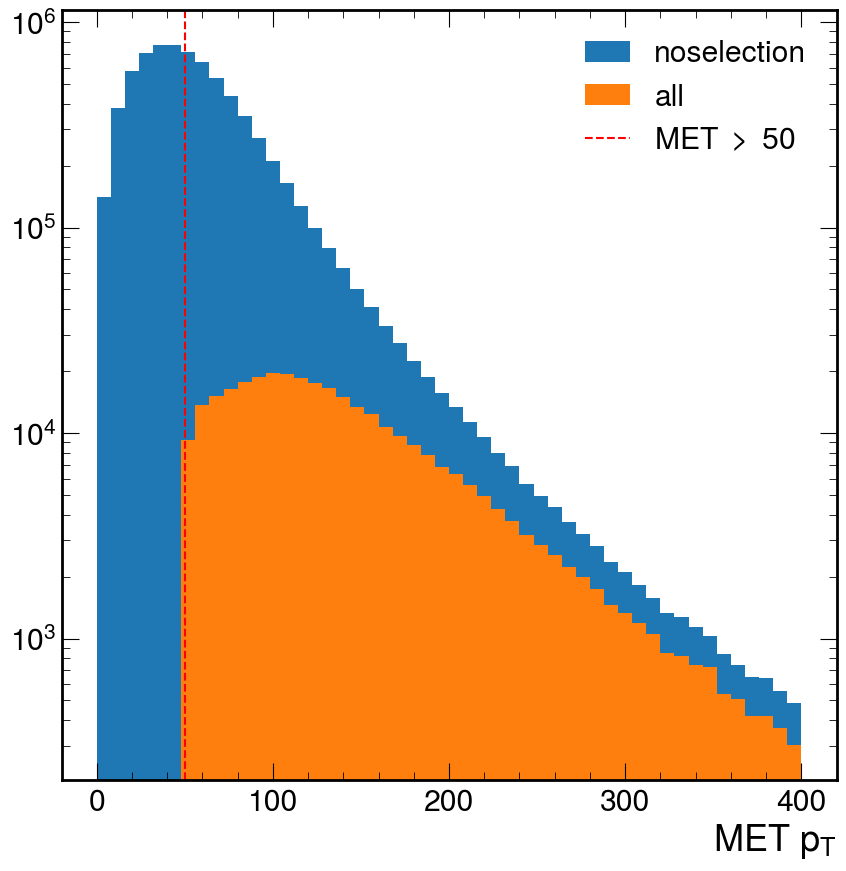

In [18]:
fig, ax = plt.subplots()

for cut in ["noselection", "all"]:

    h = out["met"].project("region", "pt")[hist.loc(cut), :]

    mplhep.histplot(h, label=cut, yerr=False, histtype='fill', alpha=1,)
    
ax.set_yscale("log")
ax.axvline(50, color='red',ls='--', label=r"MET $>$ 50")
ax.legend()

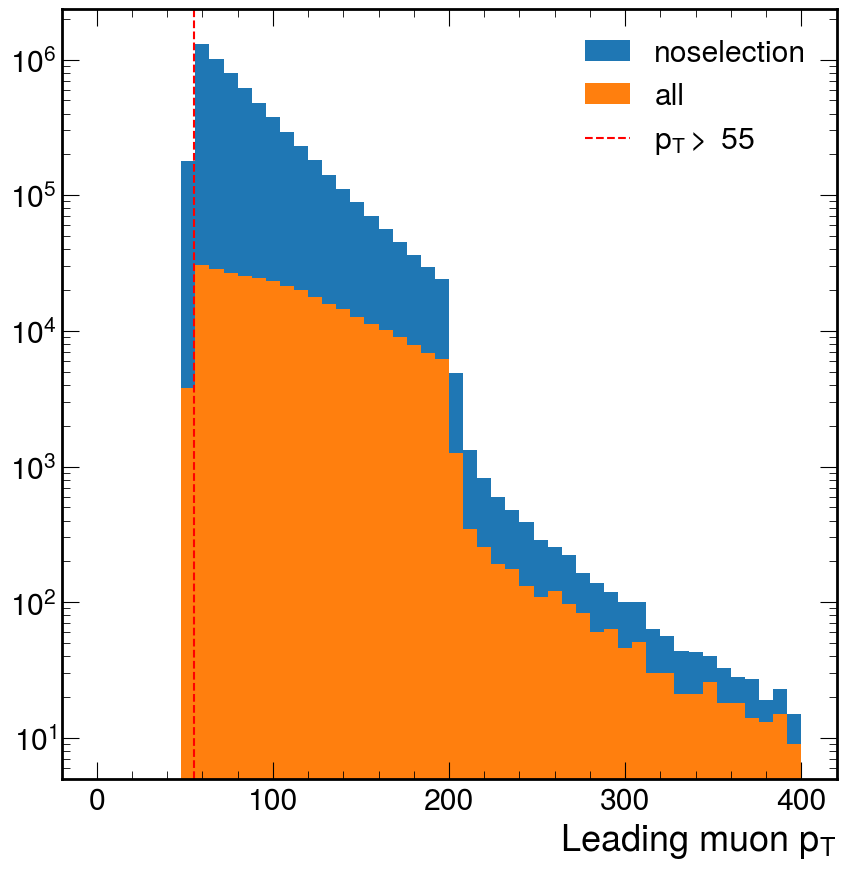

In [19]:
fig, ax = plt.subplots()

for cut in ["noselection", "all"]:

    h = out["goodmuon"].project("region", "pt")[hist.loc(cut), :]

    mplhep.histplot(h, label=cut, yerr=False, histtype='fill', alpha=1,)

ax.set_yscale("log")
ax.axvline(55, color='red',ls='--', label=r"p$_T >$ 55")    
ax.legend()

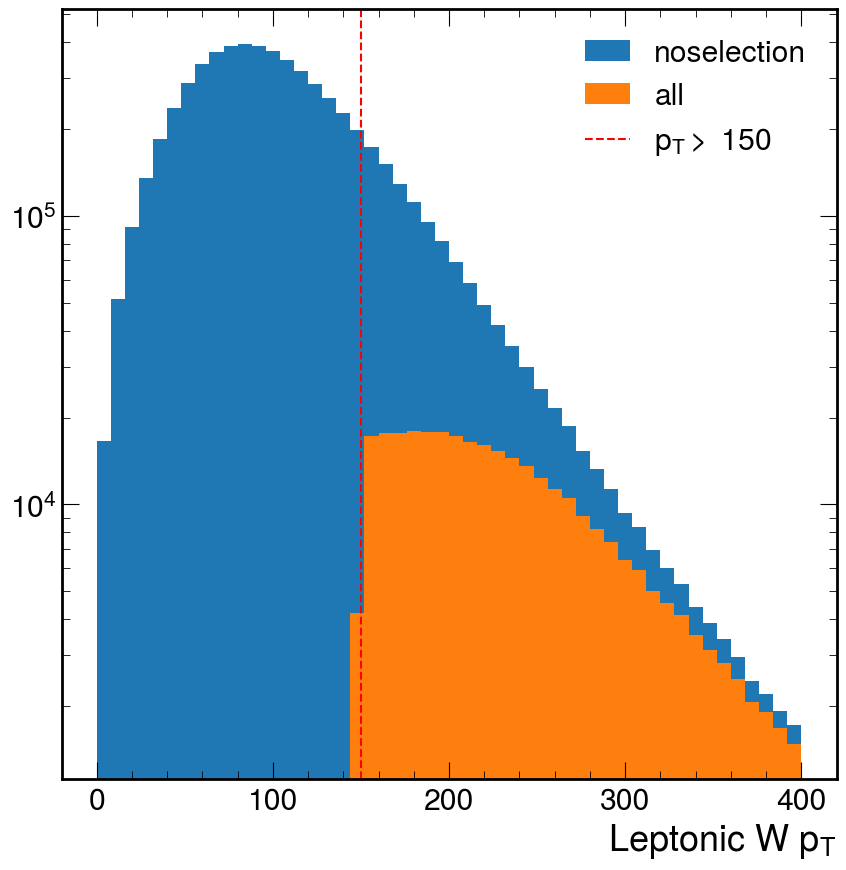

In [20]:
fig, ax = plt.subplots()

for cut in ["noselection", "all"]:

    h = out["leptonicW"].project("region", "pt")[hist.loc(cut), :]

    mplhep.histplot(h, label=cut, yerr=False, histtype='fill', alpha=1,)

ax.set_yscale("log")
ax.axvline(150, color='red',ls='--', label=r"p$_T >$ 150")    
ax.legend()

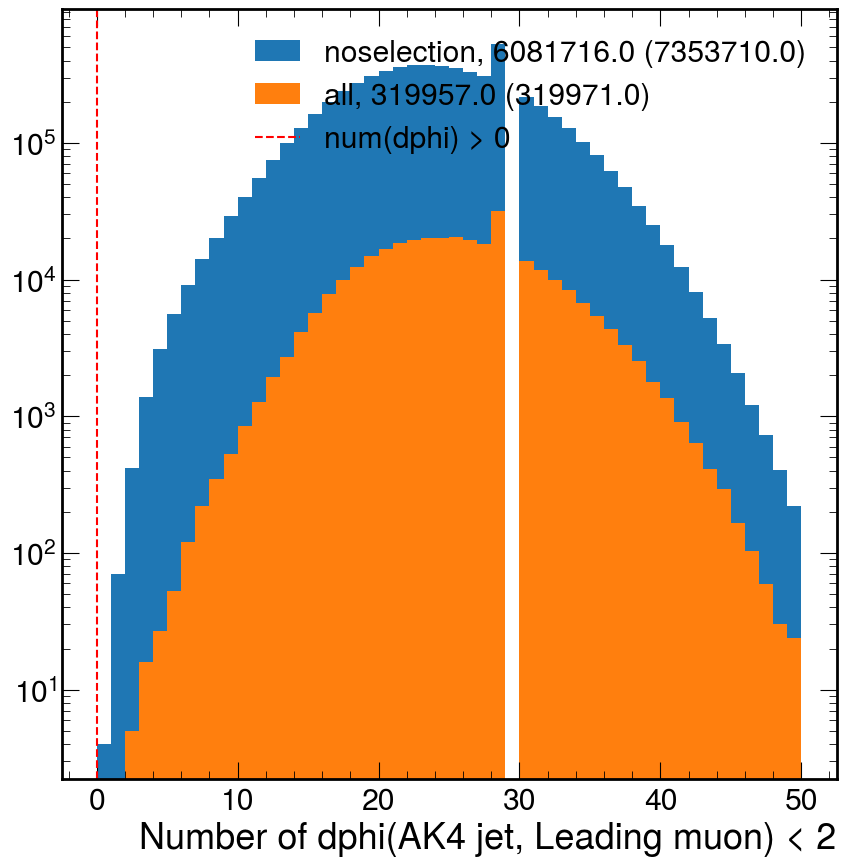

In [21]:
fig, ax = plt.subplots()

for cut in ["noselection", "all"]:

    h = out["ak4bjet"].project("region", "njets")[hist.loc(cut), :]

    mplhep.histplot(h, label=cut + ", {0} ({1})".format(h.sum(), h.sum(flow=True)), yerr=False, histtype='fill', alpha=1,)

    ax.set_yscale("log")
ax.axvline(0, color='red',ls='--', label=r"num(dphi) > 0")    
ax.legend()

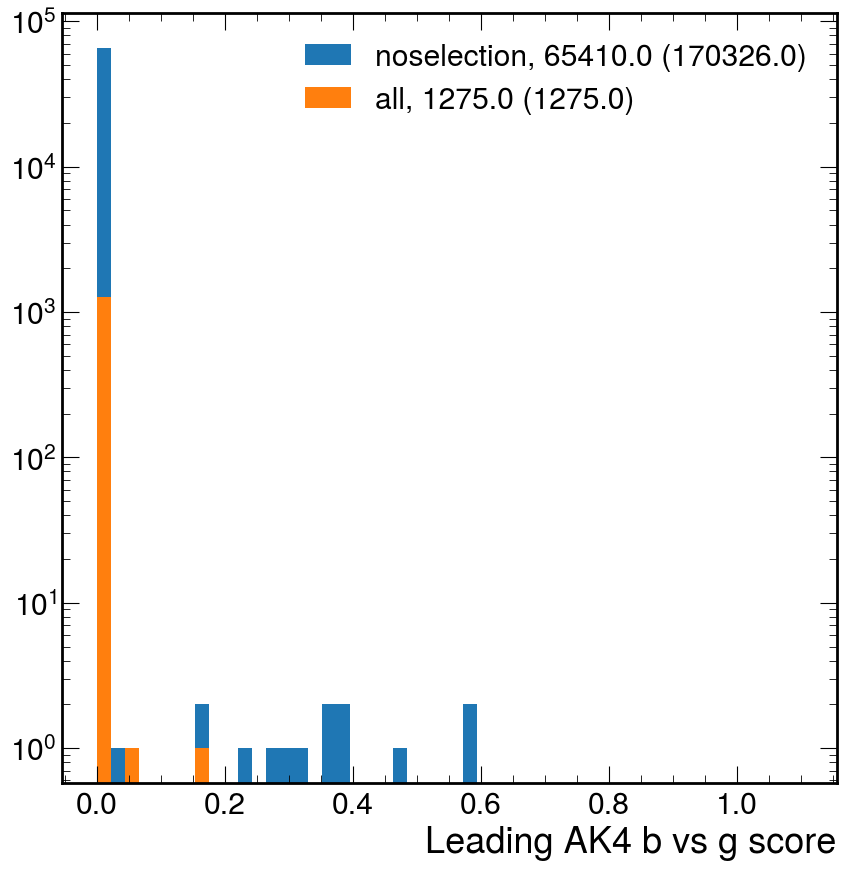

In [27]:
fig, ax = plt.subplots()

for cut in ["noselection", "all"]:

    h = out["ak4bjet"].project("region", "pn_b_1")[hist.loc(cut), :]

    mplhep.histplot(h, label=cut + ", {0} ({1})".format(h.sum(), h.sum(flow=True)), yerr=False, histtype='fill', alpha=1,)

ax.set_yscale("log")
ax.legend()

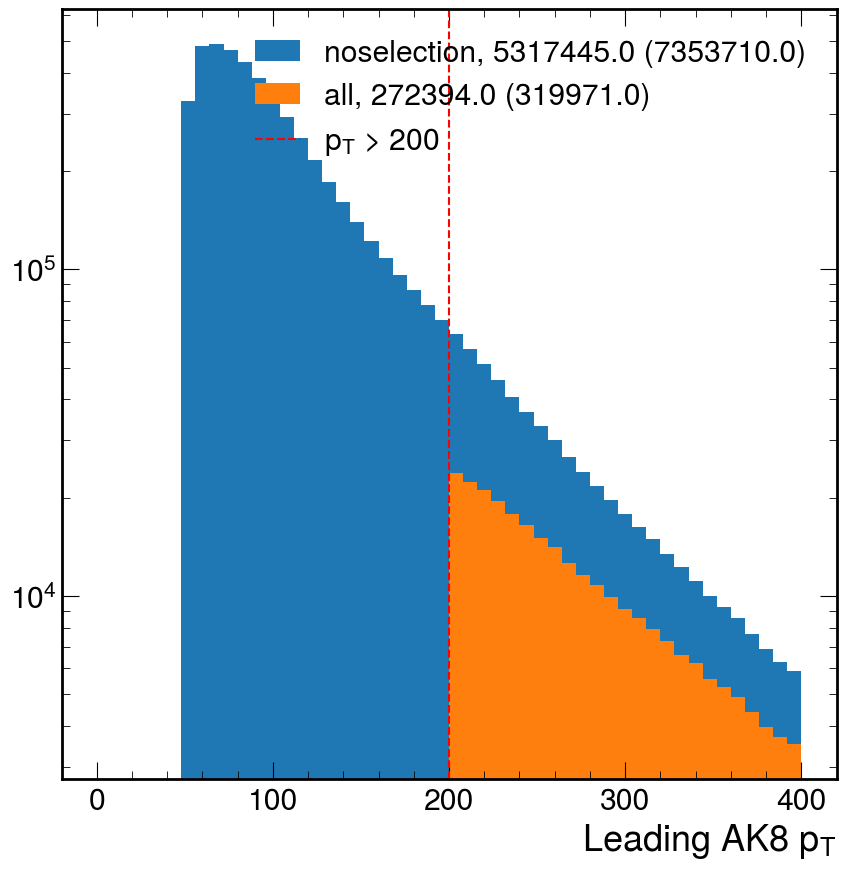

In [23]:
fig, ax = plt.subplots()

for cut in ["noselection", "all"]:

    h = out["ak8jet"].project("region", "pt")[hist.loc(cut), :]

    mplhep.histplot(h, label=cut + ", {0} ({1})".format(h.sum(), h.sum(flow=True)), yerr=False, histtype='fill', alpha=1,)

ax.set_yscale("log")
ax.axvline(200, color='red',ls='--', label=r"p$_T$ > 200")    
ax.legend()

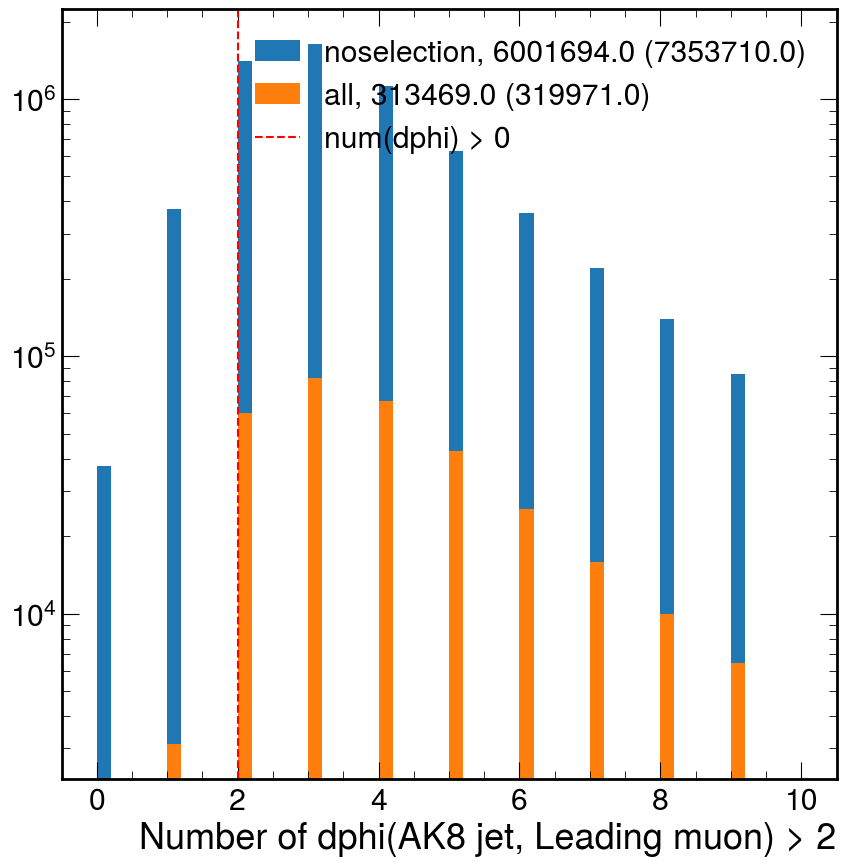

In [24]:
fig, ax = plt.subplots()

for cut in ["noselection", "all"]:

    h = out["ak8jet"].project("region", "njets")[hist.loc(cut), :]

    mplhep.histplot(h, label=cut + ", {0} ({1})".format(h.sum(), h.sum(flow=True)), yerr=False, histtype='fill', alpha=1,)

ax.set_yscale("log")
ax.axvline(2, color='red',ls='--', label=r"num(dphi) > 0")    
ax.legend()

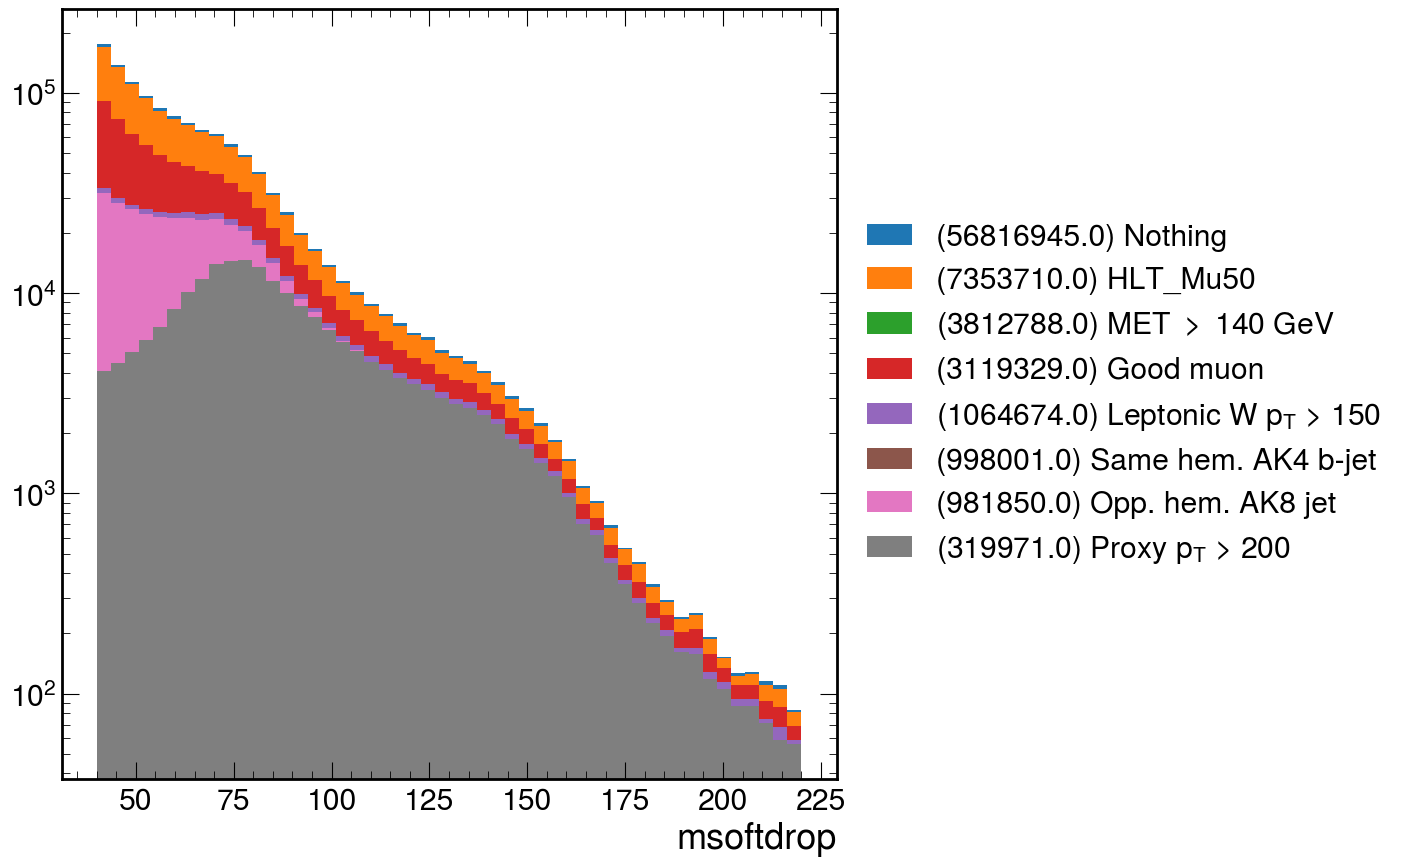

In [25]:
fig, ax = plt.subplots()


for cut in np.arange(0, 8):

    h = out["cutflow"].project("region", "cut", "msoftdrop")[hist.loc("all"), hist.loc(cut), :]

    mplhep.histplot(h, label=f"({h.sum(flow=True)}) " + df.index[cut], yerr=False, histtype='fill', alpha=1,)
    
ax.set_yscale("log")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [176]:
import json

fileset = {}

with open("inputfiles/run2022d.json") as fin:
    fileset = json.load(fin)

In [177]:
from distributed import Client
from lpcjobqueue import LPCCondorCluster

from dask.distributed import performance_report
from dask_jobqueue import HTCondorCluster, SLURMCluster

env_extra = [
    f"export PYTHONPATH=$PYTHONPATH:{os.getcwd()}",
]

cluster = LPCCondorCluster(
    ship_env=True,
    memory="8GB",
)

cluster.adapt(minimum=1, maximum=100)
client = Client(cluster)

print("Waiting for at least one worker...")
client.wait_for_workers(1)

uproot.open.defaults["xrootd_handler"] = uproot.source.xrootd.MultithreadedXRootDSource

out = processor.run_uproot_job(
            fileset,
            "Events",
            processor_instance=Processor(),
            executor=processor.dask_executor,
            executor_args={
                "schema": ScoutingNanoAODSchema,
                #"savemetrics": True,
                "retries": 3,
                "client": client,
                'skipbadfiles':True,
            },
            chunksize=10000,
            #maxchunks=args.max,
        )

util.save(out, "outfiles/cutflow_Run2022D.coffea")

/opt/conda/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34558 instead
  warnings.warn(


Waiting for at least one worker...
[####################################### ] | 99% Completed |  2hr 33min 52.6s

For details, see https://htcondor-wiki.cs.wisc.edu/index.cgi/wiki?p=PlanToReplaceGridCommunityToolkit


In [180]:
out = util.load("outfiles/cutflow_Run2022D.coffea")

out["cutflow"].project("msoftdrop")

Hist(Regular(50, 40, 220, name='msoftdrop'), storage=Double()) # Sum: 28992.0 (326115270.0 with flow)